# Importing necessary functions 

In [42]:
import numpy as np
import pandas as pd 
import datetime 
import time 
import seaborn as sns 
import matplotlib.pyplot as plt
import collections
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from pylab import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
plt.rcParams["figure.figsize"] = [9,5]
sns.set(rc={'figure.figsize':(6,3)})

# Defining Functions

In [43]:
def zscore(series):
    return (series - series.mean())/series.std()

def mean(series):
    return series.sum()/series.count()

def log_function(series):
    return np.log(series)

# Importing the datasets 

In [44]:
dengue_features_train = pd.read_csv('/Users/harshitgola/Downloads/Dengue/dengue_features_train.csv')
dengue_labels_train = pd.read_csv('/Users/harshitgola/Downloads/Dengue/dengue_labels_train.csv')

# Merging both the datasets on common fields and setting the date object as index and checking datatypes

Merging the two datasets on the basis of common fields in the dataset i.e. city, year and weekofyear and converting the city variable datatype from string to category. 

In [45]:
df_merged = pd.merge(dengue_features_train, dengue_labels_train, on=['city', 'year', 'weekofyear'])
df_merged['week_start_date'] = df_merged['week_start_date'].astype('datetime64[ns]')
df_merged.city = df_merged.city.astype('category')
df_merged.set_index('week_start_date', inplace=True)
print(df_merged['city'].value_counts(normalize=True))
df_merged.info()

sj    0.642857
iq    0.357143
Name: city, dtype: float64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1456 entries, 1990-04-30 to 2010-06-25
Data columns (total 24 columns):
city                                     1456 non-null category
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
re

# Checking the distribution of the data within the two cities from 1990 to 2010

Notice that here, Distribution of data is uneven within the two cities. As we can observe, there are no cases for Iquitos city from 1990 to 1999. Also, there is no data present for San Juan city for the years 2009 and 2010. 

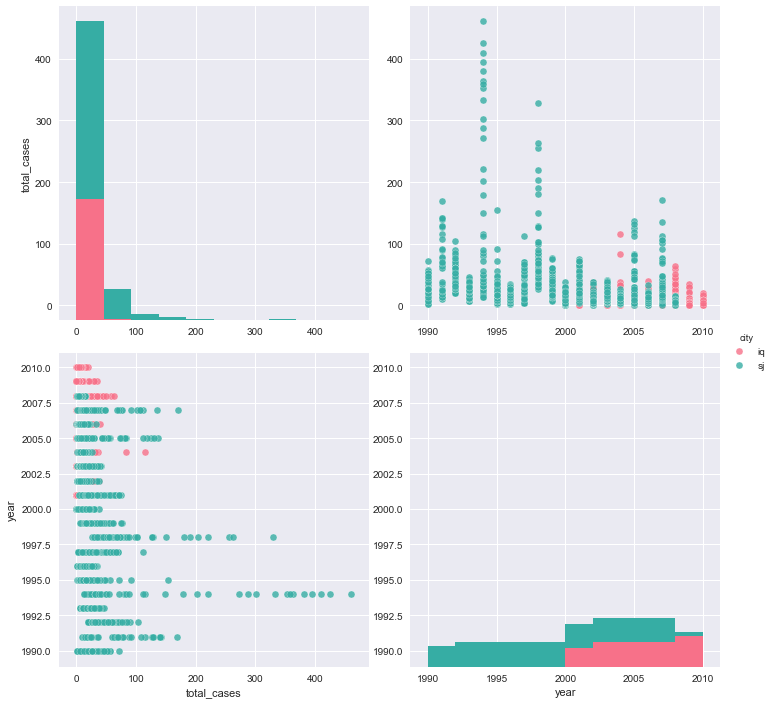

In [70]:
sns.pairplot(df_merged, 
            vars=['total_cases', 'year'],
            hue='city', 
            palette='husl',
            plot_kws={'alpha':0.8},
            size=5)
plt.show()

# Dengue cases in San Juan from 1990 to 1999 (ONLY SAN JUAN)

As we just observed, there is no data for Iquitos for the years 1990 to 1999. So, plotting the overall sum of dengue cases received in San Juan city during this period. 

We can observe that 1994 and 1998 were the two years when there was unexpected surge or more than expected (i.e. outliers) in the number of dengue cases received. 

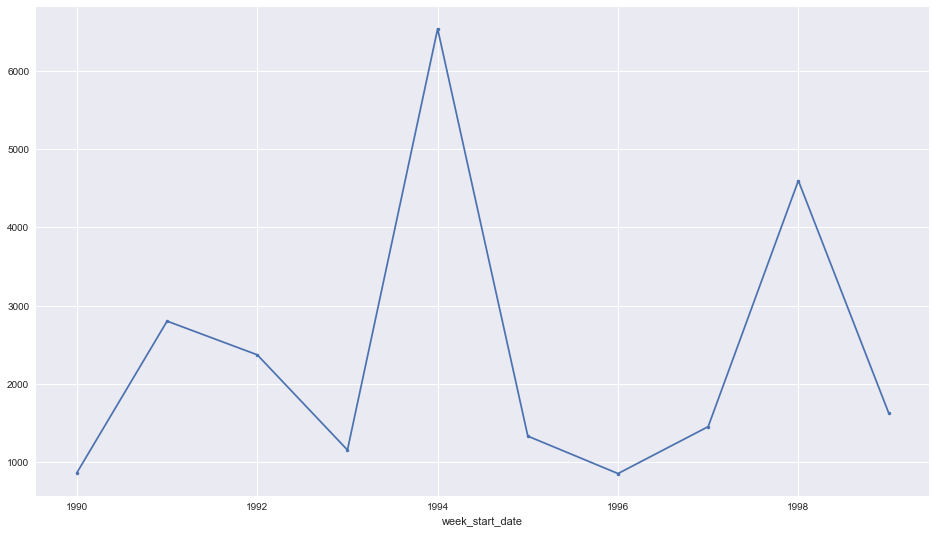

In [47]:
plt.rcParams["figure.figsize"] = [16,9]
df_till_1999 = df_merged.loc['1990':'1999', :]
df_till_1999['total_cases'].resample('A').sum().plot(kind='line', marker='.')
plt.show()

# Dengue Cases within the two cities from 2000 to 2010

Now, plotting for the years 2000 to 2010 we have data distribution within both the cities except for the years 2009 and 2010 in which we don't have any data for San Juan city. 

From the figure, it is evident that there is a negative correlation between these two cities when trying to compare the dengue cases each year. 

We can observe, that when there is a surge in number of dengue cases in San Juan city, there is a decrease in the number of cases in Iquitos city from it's following year and vice versa. 

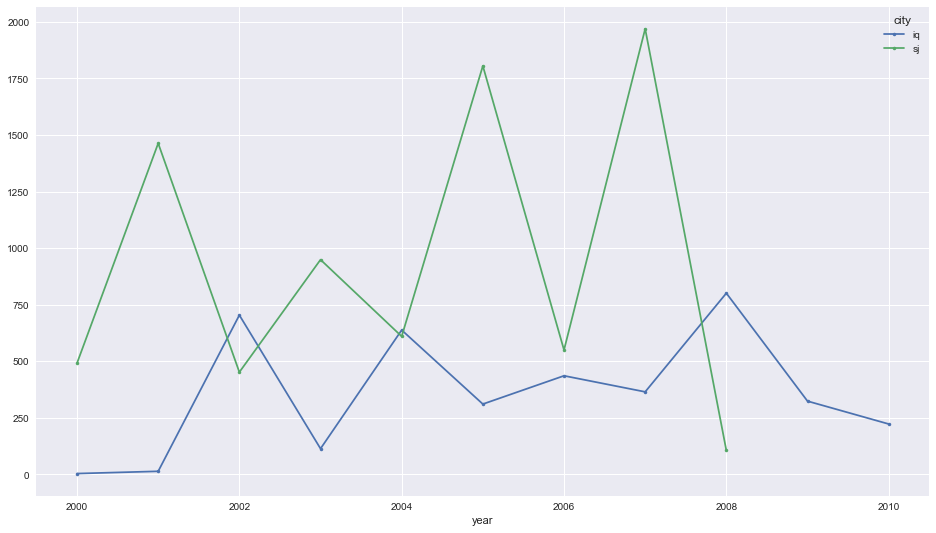

In [48]:
plt.rcParams["figure.figsize"] = [16,9]
df_2000_2010 = df_merged.loc['2000':'2010',:]
df_2000_2010.groupby(['year', 'city'])['total_cases'].sum().unstack().plot(kind='line', marker='.')
plt.show()

# Checking the spread of the cases within the two cities from 2000 to 2010 

WIKIPEDIA REFERENCE: https://www.cdc.gov/dengue/about/inpuerto.html

Dengue continues to be endemic in Puerto Rico, with three to nine thousand suspected dengue cases reported during non-outbreak years. Since 1990, there have been four large epidemics of dengue. In 1994 there were 24,700 suspected dengue cases reported, in 1998 there were 17,000 cases reported and in 2007 there were 10,508 cases reported.


From this plot, we can observe that there is a lot of variability in the number of cases received in San Juan as compared to Iquitos. 

Also, we can identify from the below plot that number of extreme cases were observed in 2007. And, from our previous plot as well we identified that 1994 and 1998 had encountered similar situation. 

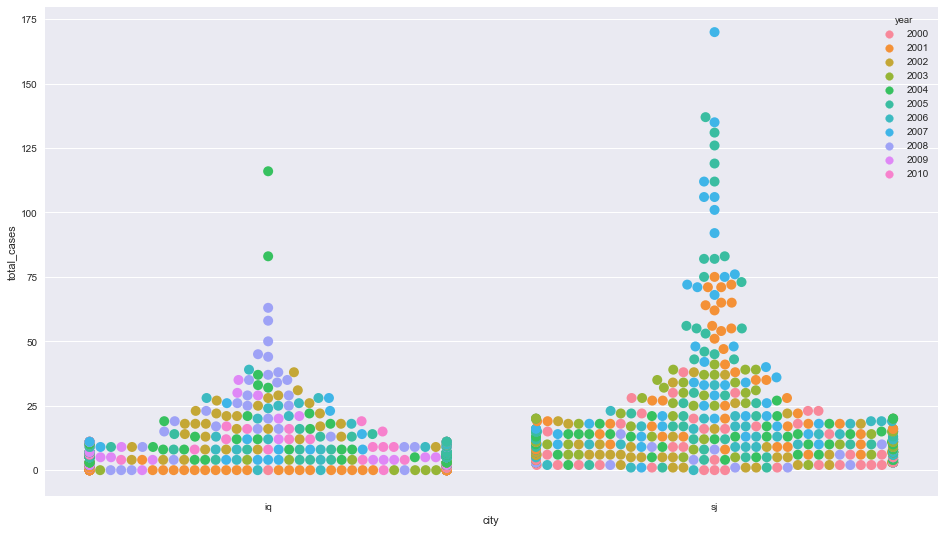

In [49]:

plt.rcParams["figure.figsize"] = [16,9]
sns.set(rc={'figure.figsize':(16,9)})
sns.swarmplot(x='city', y='total_cases', data=df_2000_2010, hue='year',size=10)
plt.show()

# Filtering dataset on the basis of cities (i.e. San Juan & Iquitos) 

In [50]:
df_merged_sj = df_merged[df_merged.loc[:,'city']=='sj']
df_merged_iq = df_merged[df_merged.loc[:,'city']=='iq']

# Checking the Seasonality in San Juan from 1990 to 2008 [Month Wise]

Weather climate of San Juan: 

Source: https://weather-and-climate.com/average-monthly-Rainfall-Temperature-Sunshine,San-Juan,Puerto-Rico

Because of it's high temperatures with a lot of precepation the humidity can be pretty high,but because of the nice sea breeze you won't experience it as too hot. 

What's the best time to go to San Juan in Puerto Rico? Here are some annual weather facts we collected from our historical climate data: 
On average, the temperatures are always high.
Most rainfall (rainy season) is seen in May, June, July, August, September, October, November and December.
On average, the warmest month is August.
On average, the coolest month is January.
May is the wettest month. This month should be avoided if you don't like too much rain.
February is the driest month.

Source: https://link.springer.com/chapter/10.1007/978-3-642-88533-4_6

Immature stages of mosquitoes are all aquatic and require water in the form of either large permanent pools and streams or temporary rainpools or even small collections of water in fallen leaves or flowers. As the seasons in the tropics are marked by fluctuation in rainfall, it is not surprising to find that populations of many mosquito species follow these seasons very closely.

Building relations between these two sources, we can say from our exploratory data analysis that mosquitoes have favorable conditions in San Juan, Puerto Rico because rainfall is too heavy as well as there is a high temperature with a lot of precipitation which in turns increases humidity. 

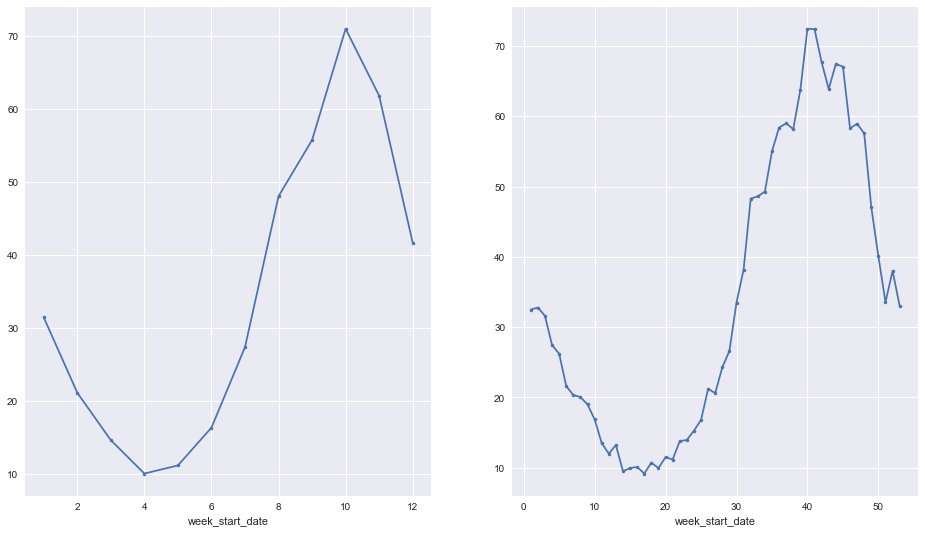

In [51]:
plt.rcParams["figure.figsize"] = [16,9]
#sns.set(rc={'figure.figsize':(9,5)})
subplot(1,2,1)
index_month_sj = df_merged_sj.index.month
total_cases_in_sj_by_month = df_merged_sj.groupby(index_month_sj)['total_cases'].mean()
total_cases_in_sj_by_month.plot(kind='line', marker='.')

subplot(1,2,2)
index_week_sj = df_merged_sj.index.week
total_cases_in_sj_by_week = df_merged_sj.groupby(index_week_sj)['total_cases'].mean()
total_cases_in_sj_by_week.plot(kind='line', marker='.')
plt.show()

# Filling missing values (using appropriate imputation method) 

Observing the dataset, I thought of many methods of replacing the missing values or eventually dropping it. 

There are missing values less than 4-5% in most of columns except ndvi_ne which accounts for 29% and ndvi_nw for 3%. rest of the data is less than 2% in which case we drop these rows. 

Another approach I thought of was using 'ffill' method but it is still a lot uncertain as we end up having a false model. 

Another approach, I thought of was taking each group (i.e. 1970) and filling the missing values with mean but this doesn't take seasonality into account. it just takes the average of particular variable in that year. 

So, observing the seasonality in San Juan, cases are decreasing during the first six month and increasing during the last 6 months, for which I thought of dividing the dataset in two parts i.e. Week 1 to Week 29 and Week 30 to Week 52 and perform mean imputation. 

In [52]:
filter_week_1_29 = (df_merged_sj.loc[:, 'weekofyear'] >=1)  & (df_merged_sj.loc[:, 'weekofyear'] <=29)
filter_week_30_52 = (df_merged_sj.loc[:, 'weekofyear'] >=30)  & (df_merged_sj.loc[:, 'weekofyear'] <=52)

df_sj_1_29 = df_merged_sj.loc[filter_week_1_29,:]
df_sj_30_52 = df_merged_sj.loc[filter_week_30_52,:]

df_sj_1_29 = df_sj_1_29.fillna(df_sj_1_29.groupby('year').transform('mean'))
df_sj_30_52 = df_sj_30_52.fillna(df_sj_30_52.groupby('year').transform('mean'))

df_sj = pd.concat([df_sj_1_29, df_sj_30_52])
df_sj.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1990-05-07,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
1990-05-14,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
1990-05-21,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
1990-05-28,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


# Normalizing the dataset using groupby and transform function

In [53]:
df_sj.weekofyear = df_sj.weekofyear.astype('category')
df_norm_sj = df_sj.groupby('year').transform(zscore)
df_final_sj = pd.concat([df_sj.iloc[:,0:3],df_norm_sj], axis=1, ignore_index=True)
df_final_sj.columns = df_sj.columns
df_final_sj.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,sj,1990,18,-0.834898,-0.928368,-0.140184,-0.414658,-0.724928,-2.300219,-2.223900,...,-1.792097,-0.724928,-2.416577,0.746980,-1.892615,-0.478693,-2.045329,-2.220407,-0.430258,-1.059313
1990-05-07,sj,1990,19,-0.126422,-0.488037,-0.752923,-0.770492,-0.480358,-1.529307,-1.372848,...,-0.734916,-0.480358,-1.380532,0.149016,-0.762993,-1.119092,-0.513710,-0.496906,-0.766214,-1.008245
1990-05-14,sj,1990,20,-2.188193,-0.135410,-0.840393,-0.523571,-0.204747,-0.841178,-0.843112,...,0.502233,-0.204747,-0.256337,-0.017085,-0.762993,-0.980628,-0.180750,-0.026860,0.722890,-1.059313
1990-05-21,sj,1990,21,-0.744529,0.690283,0.352938,0.522221,-0.655790,-0.592831,-0.417586,...,0.049102,-0.655790,-0.390196,0.281897,-0.090297,-0.634465,0.551763,0.364845,-0.975052,-1.110382
1990-05-28,sj,1990,22,0.267509,0.886494,0.753947,0.706390,-0.840158,0.048733,0.112150,...,0.081550,-0.840158,0.018998,1.643926,1.217018,2.515609,1.683829,0.834891,-0.893333,-0.957176


# Heatmap to show relation between the variables: year, weekofyear and totalcases in San Juan City 

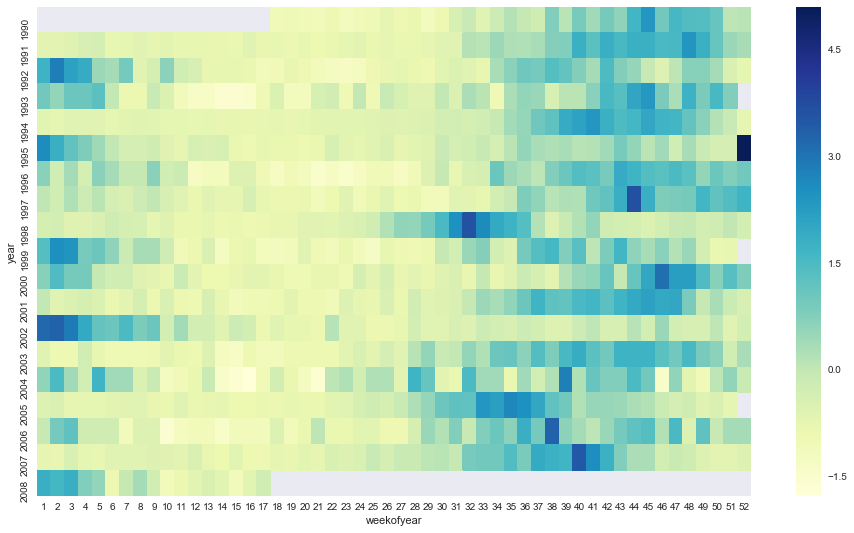

In [54]:
temp_sj = df_final_sj.pivot('year', 'weekofyear', 'total_cases')
ax = sns.heatmap(temp_sj, cmap='YlGnBu')
plt.show()

# Feature Engineering 

# Finding the correlations between the variables within the dataset 

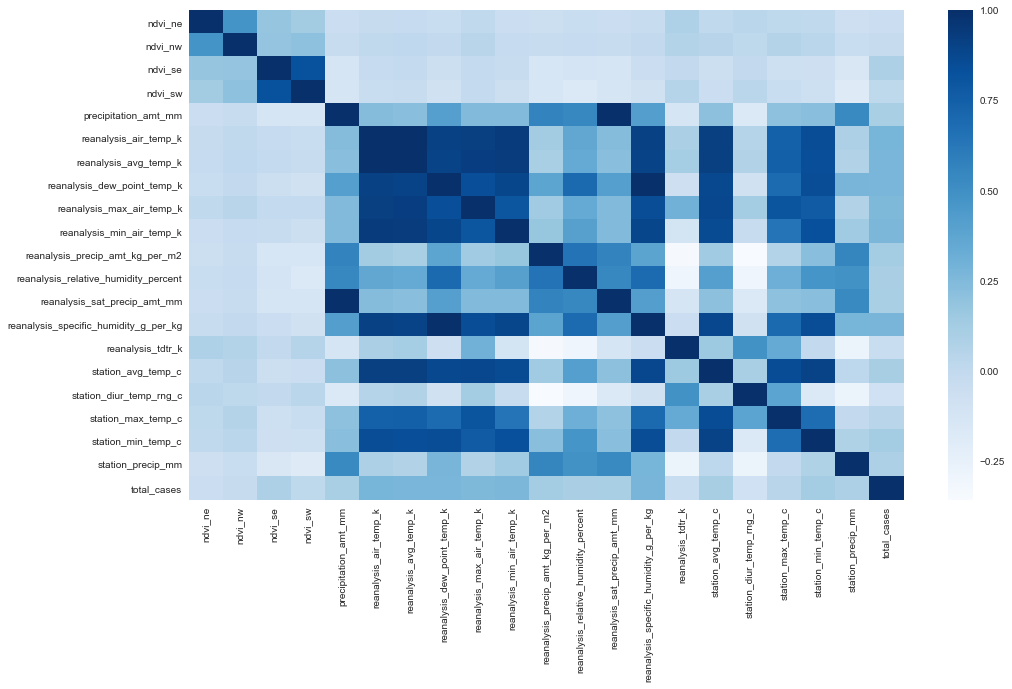

In [55]:
sj_corr = df_final_sj.iloc[:,2:].corr()
sns.heatmap(sj_corr, cmap='Blues')
plt.show()

# Checking multicollinearity and eliminating the low important variables in our analysis

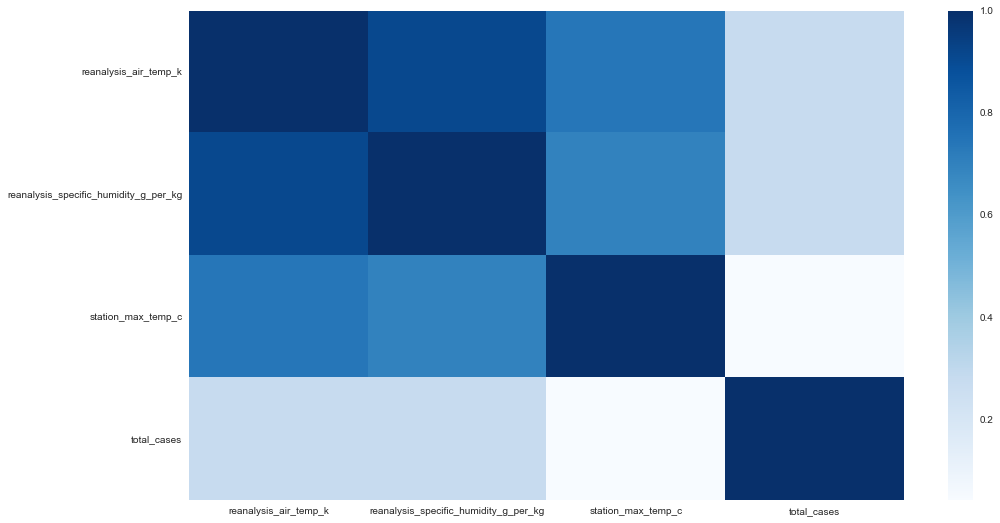

In [56]:
df_train_sj = df_final_sj.iloc[:, [8,16, 20,23]]
sns.heatmap(df_train_sj.corr(), cmap='Blues')
plt.show()

# Function for Lasso Regression

In [57]:
def lasso_regressor(X,y, names):
    
    lasso = Lasso(alpha=0.1)

    lasso_coef = lasso.fit(X_new, y_new).coef_

    plt.plot(range(len(names)), lasso_coef)

    plt.xticks(range(len(names)), names, rotation=90)

    plt.ylabel('Coefficients')

    plt.show()

# Function for Random Forest Algorithm 

In [58]:
def random_forest_regressor(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        test_size=0.3, 
                                                        random_state=21)


    rf = RandomForestRegressor(n_estimators=500,
                               min_samples_leaf=0.1,
                               random_state=21)

    rf.fit(X_train, y_train)

    return rf

# Implementing Lasso Regressor for finding the important features in the dataset

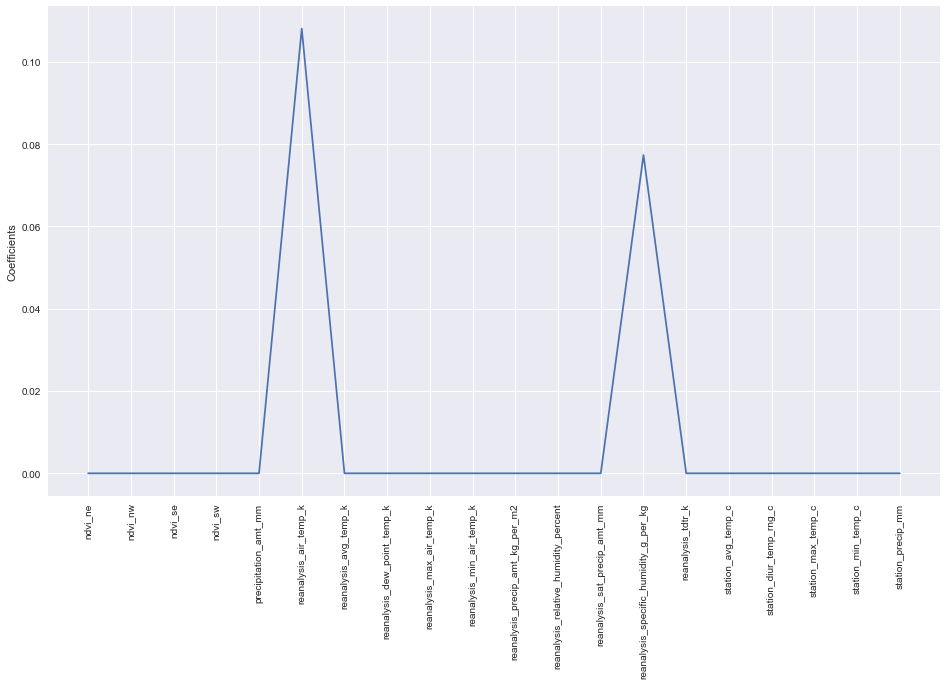

In [59]:
names = df_final_sj.iloc[:,3:].drop('total_cases', axis=1).columns
X_new = df_final_sj.iloc[:,3:].drop('total_cases', axis=1).values
y_new = df_final_sj['total_cases'].values
lasso_regressor(X_new, y_new, names)

# Features Importance using sklearn random forest algorithm on standardized dataset for San Juan city

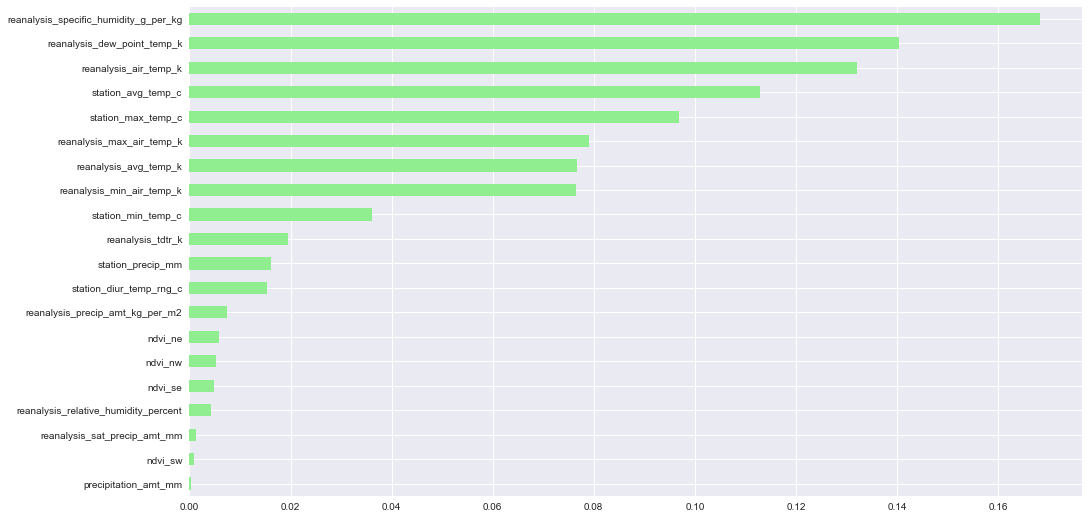

In [60]:
X = df_norm_sj.drop('total_cases', axis=1).values
y = df_norm_sj['total_cases'].values

rf = random_forest_regressor(X,y)
importances_rf = pd.Series(rf.feature_importances_, index=df_norm_sj.iloc[:,:-1].columns)

sorted_importances_rf = importances_rf.sort_values()

sorted_importances_rf.plot(kind='barh', color='lightgreen')

plt.show()

# Determinig the predictor variable i.e. total cases

# Checking the mean distribution of cases across all the years from 1900 to 2008 

In our dataset, we have mean value of total cases recorded as 34 with a standard deviation of 51 which means that there are many values which are extremely huge as compared to the small values. For example, we have some years in which average cases recorded are 125 whereas there are some years where average is not even 10. 

So, taking log values can help us to improvise the distribution across all the variables. 

In [61]:
df_sj.groupby('year')['total_cases'].mean( )

year
1990     24.742857
1991     53.865385
1992     45.596154
1993     22.078431
1994    125.634615
1995     25.634615
1996     16.442308
1997     27.961538
1998     88.365385
1999     30.862745
2000      9.461538
2001     28.134615
2002      8.692308
2003     18.250000
2004     11.730769
2005     35.196078
2006     10.576923
2007     37.865385
2008      6.235294
Name: total_cases, dtype: float64

# Transforming the total_cases with log to penalize the high values in our dataset and scale it 

Now, for taking log value, it is important to eliminate the rows which have 0 value as log(0) returns -Inf which is not reliable for modeling purpose

In [62]:
filter_zeroes = (df_sj.loc[:, 'total_cases'] != 0)
df_sj_no_zeros = df_sj.loc[filter_zeroes,:]
df_sj_no_zeros.total_cases = df_sj_no_zeros.total_cases.apply(log_function)
df_sj_no_zeros.head()

/Users/deeplakkad/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,1.386294
1990-05-07,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,1.609438
1990-05-14,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,1.386294
1990-05-21,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,1.098612
1990-05-28,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,1.791759


# Total Cases variable distribution before using log function

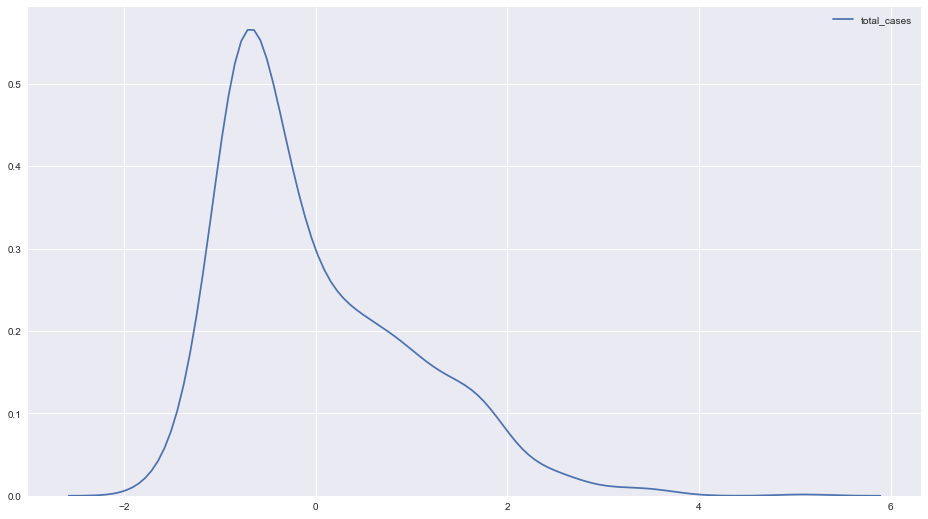

In [63]:
sns.kdeplot(df_norm_sj.total_cases)
plt.show()

# Total Cases variable distribution after applying log function

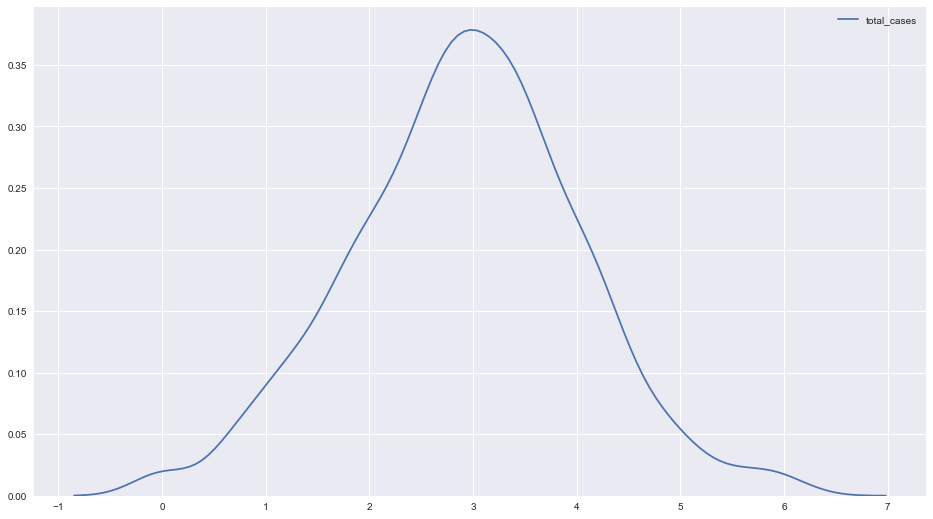

In [64]:
sns.kdeplot(df_sj_no_zeros.total_cases)
plt.show()

# Machine Learning Models 

# Grid Search CV 

In [65]:
def perform_grid_search_cv(grid_dt, X_train, X_test, y_train, y_test):
    grid_dt.fit(X_train, y_train)
    best_hyperparams = grid_dt.best_params_
    best_cv_score = grid_dt.best_score_
    best_model = grid_dt.best_estimator_ 
    test_acc = best_model.score(X_test, y_test)
    print(best_hyperparams)
    print(best_cv_score)
    print(best_model)
    print(test_acc)
    

# Performing Decision Trees Algorithm to check the accuracy of our model to predict the total dengue cases in San Juan city 

In [66]:
dt = DecisionTreeRegressor(random_state=1)

params_dt = {
    'max_depth':[3,4,5,6],
    'min_samples_leaf': [0.04, 0.06, 0.08],
    'max_features':[0.2,0.4,0.6,0.8]
}


grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,
                       scoring='r2',
                       cv=10,
                       n_jobs=1
                      )



X = df_sj_no_zeros.groupby('year').transform(zscore)
X = X.iloc[:, [8,16,20]].values
y = df_sj_no_zeros.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3, 
                                                    random_state=1)

perform_grid_search_cv(grid_dt, X_train, X_test, y_train, y_test)

{'max_depth': 3, 'max_features': 0.8, 'min_samples_leaf': 0.04}
0.5440199634628498
DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=0.8,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=0.04,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')
0.5223052605117107


# Performing Random Forest Algorithm to check the accuracy of our model to predict the total dengue cases in San Juan city 

In [67]:
rf = RandomForestRegressor(random_state=21)

params_dt = {
    'n_estimators': [100,300,500,700],
    'min_samples_leaf': [0.04, 0.06, 0.08]
}


grid_dt = GridSearchCV(estimator=rf,
                       param_grid=params_dt,
                       scoring='r2',
                       cv=10,
                       n_jobs=1
                      )



X = df_sj_no_zeros.groupby('year').transform(zscore)
X = X.iloc[:, [8,16,20]].values
y = df_sj_no_zeros.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3, 
                                                    random_state=1)

perform_grid_search_cv(grid_dt, X_train, X_test, y_train, y_test)

{'min_samples_leaf': 0.04, 'n_estimators': 700}
0.5365369747478494
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=0.04, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=1,
           oob_score=False, random_state=21, verbose=0, warm_start=False)
0.5526480848492491


# Performing Gradient Boosting Algorithm to check the accuracy of our model to predict the total dengue cases in San Juan city 

In [69]:
gbt = GradientBoostingRegressor(random_state=21)
params_dt = {
    'n_estimators': [100,300,500,700],
    'min_samples_leaf': [3, 4, 6, 8],
    'max_depth':[3,4,5,6],
    'learning_rate': [0.01,0.05, 0.10, 0.12]
}


grid_dt = GridSearchCV(estimator=gbt,
                       param_grid=params_dt,
                       scoring='r2',
                       cv=10,
                       n_jobs=1
                      )



X = df_sj_no_zeros.groupby('year').transform(zscore)
X = X.iloc[:, [8,16,20]].values
y = df_sj_no_zeros.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3, 
                                                    random_state=1)

perform_grid_search_cv(grid_dt, X_train, X_test, y_train, y_test)

{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 100}
0.6058133825888607
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=4,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=21,
             subsample=1.0, verbose=0, warm_start=False)
0.598110475380121


# Conclusion

I used a several ways to ways to perform statistical modeling on the dataset that can predict total cases. 

IMPUTATION METHOD: 

First method: 

Performing the imputation method and replacing all missing values with 'ffill' and normalized the whole dataset using groupby and transform function. Further, I used the decision trees algorithm, which returned the mean absolute error of 0.78. 

Second Method: 

Performed the imputation method by splitting the dataset into the two parts i.e. week 1 to week 29 and week 30 to week 52 and fill the missing values by mean of that particular group for each year. This took the seasonality into account. 


FEATURE ENGINEERING: 

First Method: 

I used Pearson Correlation Method for finding the variables that are showing a strong correlation with our predictor variable i.e. total cases.

I eliminated the variables that were having weak correalation and also the variables that were internally correlated with each other to deal with multicollinearity issue. 

Second Method: 

I used Lasso Regressor for finding the key features in our dataset. Basically, it helps to determine the coefficients that are having a strong influence on our predictor variables and multiply the coefficients of weak variables with 0 so we only get those which are important for our analysis. 

Third Method: 

I used Random forest algorithm for finding the key features and it returns a nice bar chart of the key variables that are showing the highest variance in our predictor variable. 


MACHINE LEARNING: 

I defined the Grid Search CV for passing different hyperparameters and returning best_params and also how are they able to perform on our test dataset by returning test accuracy


I implemented three algorithms i.e. Random Forest, Decision Trees and Gradient Boosting algorithms by taking the total cases as our dependent variable and rest of the variables as our independent variable 


Dependent Variable: I used log function on it because there were some years where mean of total cases were less than 10 and there were some years where mean of total cases was 125. Log helps to transform the large values and make it on the same scale as small values by reducing the gap between the two. 



First Method: 

USING ALL INDEPENDENT VARIABLES: 

Test accuracy OF Decision Trees, Random Forest, Gradient Boosting is 0.51, 0.53, 0.

Second Method:

USING ONLY IMPORTANT VARIABLES DETERMINED BY OUR FEATURE ENGINEERING MODEL 
i.e. reanalysis_air_temp_k, reanalysis_specific_humidity_g_per_kg, statiton_max_temp_c

Test accuracy of Decision Trees, Random Forest, Gradient Boosting is 0.52, 0.55, 0.59 respectively

Thus, we were not only able to increase the accuracy of our model but also we were able to reduce the feature variables in our dataset to predict the total dengue cases in San Juan. 

# Future Goal:

I have done this project for San Juan City. Providing the Exploratory Data Analysis we can see that there is a negative correlation between the dengue cases occuring in both the cities. 

Similarly, we can perform steps to identify the feature variables in Iquitos city as well. 

Future goal: 
We can try Multivariate Time Series Forecasting with LSTMs in Keras